In [1]:
!pip install transformers==4.33.2 trl==0.5.0 peft==0.5.0 bitsandbytes==0.41.1 accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


In [2]:
from dataclasses import dataclass
import torch
import os, time , json, gc
from IPython.display import display, Markdown

import numpy as np
import pandas as pd

import transformers
from transformers import (AutoTokenizer, AutoModelForCausalLM, 
                          AutoModelForSequenceClassification, TrainingArguments,
                          BitsAndBytesConfig)

from datasets import Dataset, DatasetDict

# fine tuning
from trl import SFTTrainer
from peft import LoraConfig, PeftModel, get_peft_model

import asyncio

# Metric
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                             f1_score, accuracy_score, precision_score, recall_score)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


In [3]:
class CFG:

    test = 0.2

    # LLM Config
    reportTo = "none"
    topK = 10
    topP = 1.0
    temperature = 0.1
    maxEpoch= 1
    evalSetp = 20
    learning_rate = 2e-4 # 1e-4

    
    gemma_dir = '/kaggle/input/gemma-2/transformers/gemma-2-9b-it-4bit/1/gemma-2-9b-it-4bit'
    lora_dir = '/kaggle/input/lora-gemma-new/pytorch/default/1/opt/tiger/kaggle/ckpt/checkpoint-170'

    trainFile = "/kaggle/input/wsdm-cup-multilingual-chatbot-arena/train.parquet"
    testFile =  "/kaggle/input/wsdm-cup-multilingual-chatbot-arena/test.parquet"
    sampleFile = "/kaggle/input/wsdm-cup-multilingual-chatbot-arena/sample_submission.csv"

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
def clearMemory():
    for _ in range(5):
        torch.cuda.empty_cache()
        gc.collect()
        time.sleep(3)

In [6]:
clearMemory()

In [7]:
def printSeriesUniqueVal(series):
    print(f"{series.unique()}")

In [8]:
def printAllColumnsValue(df, showAll=True):
    for col in df.columns:
        if showAll:
            print(f"{col} : {df[col].unique()}") # print unique value
        else:
            if df[col].dtype == "object": #only print catergory type column
                print(f"{col} : {df[col].unique()}")

In [9]:
trainDF = pd.read_parquet(CFG.trainFile)
trainDF

,id,prompt,response_a,response_b,winner,model_a,model_b,language
0,00007cff95d7f7974642a785aca248b0f26e60d3312fac...,vieš po Slovensky?,"Áno, hovorím po slovensky. Ako vám môžem pomôcť?","Áno, veď som tu! Môžem ti pomôcť s otázkami al...",model_a,o1-preview,reka-core-20240904,Slovak
1,00010ed04b536f56ebe43eef1100c13906abea12bf9855...,You will be given a piece of news. Analyze it ...,Let's break down the news and analyze it accor...,"```json\n{\n ""contains_orgs"": true,\n ""orgs""...",model_a,gemma-2-27b-it,gemini-1.5-flash-002,Russian
2,0003800d510e38803efba5ceaec122bc66408fe367b0be...,"Dört basamaklı, rakamları birbirinden ve sıfır...","Bu soruyu çözmek için, verilen koşulları adım ...",Bu problemi adım adım çözelim:\n\n1) ABCD - DC...,model_a,gpt-4-0125-preview,claude-3-5-sonnet-20240620,Turkish
3,00072026c68f5418ef2da238394e418ce72a534b9b22d5...,"현재 추천된 탑 3 종목인 Cabaletta Bio (CABA), Rocket Ph...","죄송하지만 저는 금융 조언을 제공할 수 없습니다. 저는 AI 모델이며, 투자 결정에...",현재 추천된 탑 3 종목에 순위를 매기기 위해서는 여러 가지 요소들을 고려해야 합니...,model_b,gemma-2-2b-it,llama-3.1-nemotron-70b-instruct,English
4,0007ce7cf6bc1b5a8f8a4669b854fb12030863c970d9dc...,Please be boring,"Alright, I'll be as boring as possible.\n\nTod...","Understood. Here is a straightforward, unadorn...",model_a,reka-flash-20240722,grok-2-2024-08-13,English
...,...,...,...,...,...,...,...,...
48434,fff5962462043091a771018e37ece11c425e9c7cca64b2...,你好，请你介绍下你自己,你好！我是LSK，一个形式为人工智能的chatbot。,### 介绍\n\n我是一款人工智能语言模型，基于深度学习技术开发而成。我的主要功能是理解自...,model_b,llama-3.2-3b-instruct,llama-3.1-8b-instruct,Chinese
48435,fffad6c95fb82e3a694b4952965852130285e0a38905d5...,Viva Technology参展费用,Viva Technology是一个国际性的科技展览会，每年在法国巴黎举行。参展费用会根据多...,我无法找到Viva Technology参展费用的具体公开信息。\n\n**参展费用通常取决...,model_a,reka-core-20240904,gemini-1.5-flash-exp-0827,English
48436,fffbf502f2cd88b706a4bd6e54ed90e9a2d59d1643140d...,다음은 '사무장병원 경찰 조사 동행기 - 장효강 변호사의 현장 이야기'라는 제목의 ...,"사무장병원 경찰 조사 동행기 - 장효강 변호사의 현장 이야기\n\n**""압수수색, ...","도입부를 개선하기 위해서는 독자의 관심을 더 끌어야 하며, 좀 더 명료하고 간결하게...",model_a,gemini-1.5-pro-002,yi-lightning-lite,Korean
48437,fffd2ffdaa03e9e0a0cd1e8f2ee80f530bb19b08fa4312...,What is the height of the church located in Sa...,**Church Information: Église de Saint-Nazaire-...,I couldn't find any information about a church...,model_a,llama-3.1-70b-instruct,llama-3.2-3b-instruct,English


In [10]:
testDF = pd.read_parquet(CFG.testFile)
testDF

,id,prompt,response_a,response_b,scored
0,327228,Caso Clínico: Un hombre de 70 años con anteced...,**Diagnóstico Diferencial de Anemia en Pacient...,"Basándonos en el caso clínico presentado, pode...",False
1,1139415,Peel Company received a cash dividend from a ...,The correct answer is **(a) No No**. Here's ...,The correct answer is **(a) No No**. Here's wh...,False
2,1235630,Há um grave problema com o relógio da torre da...,Dois problemas interessantes!\n\n**Problema 1:...,Vamos resolver os dois problemas em sequência....,False


In [11]:
testDF.columns

Index(['id', 'prompt', 'response_a', 'response_b', 'scored'], dtype='object')

In [12]:
submit = pd.read_csv(CFG.sampleFile)
submit

,id,winner
0,327228,model_a
1,1139415,model_a
2,1235630,model_a


In [13]:
trainDF["language"].value_counts()[:50] # top 50 language

language
English       25211
Russian        6455
Chinese        4310
Vietnamese     3103
German         1402
Japanese       1159
unknown        1128
Korean         1041
Spanish         790
French          640
Portuguese      558
Persian         366
Italian         269
Turkish         212
Czech           165
Arabic          163
Polish          158
Ukrainian       153
Dutch           123
Hungarian       109
Indonesian       66
Slovak           54
Swedish          54
Danish           53
Finnish          50
Serbian          49
Bulgarian        36
Hebrew           33
Thai             32
Romanian         26
Latin            26
Galician         22
Norwegian        17
Catalan          16
Greek            16
Lithuanian       14
Croatian         13
Sanskrit         12
Estonian         11
Scots            10
Basque           10
Uzbek             9
Tagalog           9
Corsican          9
Macedonian        9
Yoruba            9
Malay             9
Xhosa             8
Esperanto         7
Armenian   

<Axes: title={'center': 'Winner Distribution'}, xlabel='winner'>

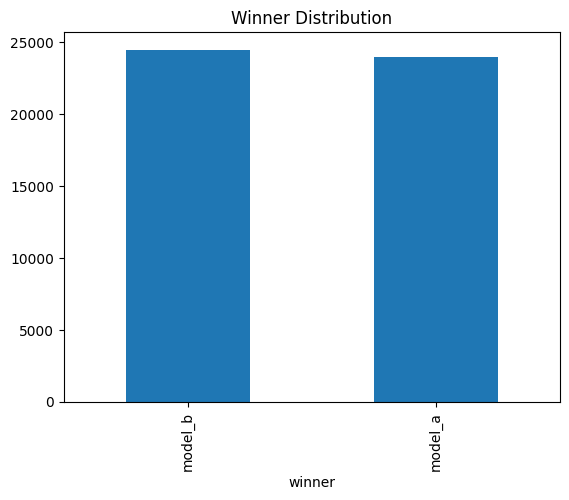

In [14]:
trainDF["winner"].value_counts().plot(kind="bar", title="Winner Distribution")

In [15]:
trainDF.columns

Index(['id', 'prompt', 'response_a', 'response_b', 'winner', 'model_a',
       'model_b', 'language'],
      dtype='object')

In [16]:
listModelA = trainDF["model_a"].unique()
listModelB = trainDF["model_b"].unique()
len(listModelA),  len(listModelB) # 60 LLM model

(60, 60)

In [17]:
sorted(listModelA)

['athene-70b-0725',
 'c4ai-aya-expanse-32b',
 'chatgpt-4o-latest-20240808',
 'chatgpt-4o-latest-20240903',
 'claude-3-5-sonnet-20240620',
 'claude-3-5-sonnet-20241022',
 'claude-3-haiku-20240307',
 'claude-3-opus-20240229',
 'command-r-08-2024',
 'command-r-plus-08-2024',
 'deepseek-coder-v2-0724',
 'deepseek-v2-api-0628',
 'deepseek-v2.5',
 'gemini-1.5-flash-001',
 'gemini-1.5-flash-002',
 'gemini-1.5-flash-8b-001',
 'gemini-1.5-flash-8b-exp-0827',
 'gemini-1.5-flash-exp-0827',
 'gemini-1.5-pro-001',
 'gemini-1.5-pro-002',
 'gemini-1.5-pro-exp-0827',
 'gemma-2-27b-it',
 'gemma-2-2b-it',
 'gemma-2-9b-it',
 'gemma-2-9b-it-simpo',
 'glm-4-plus',
 'gpt-4-0125-preview',
 'gpt-4-1106-preview',
 'gpt-4-turbo-2024-04-09',
 'gpt-4o-2024-05-13',
 'gpt-4o-2024-08-06',
 'gpt-4o-mini-2024-07-18',
 'grok-2-2024-08-13',
 'grok-2-mini-2024-08-13',
 'internlm2_5-20b-chat',
 'jamba-1.5-large',
 'jamba-1.5-mini',
 'llama-3.1-405b-instruct-bf16',
 'llama-3.1-405b-instruct-fp8',
 'llama-3.1-70b-instruct',

In [18]:
sorted(listModelB)

['athene-70b-0725',
 'c4ai-aya-expanse-32b',
 'chatgpt-4o-latest-20240808',
 'chatgpt-4o-latest-20240903',
 'claude-3-5-sonnet-20240620',
 'claude-3-5-sonnet-20241022',
 'claude-3-haiku-20240307',
 'claude-3-opus-20240229',
 'command-r-08-2024',
 'command-r-plus-08-2024',
 'deepseek-coder-v2-0724',
 'deepseek-v2-api-0628',
 'deepseek-v2.5',
 'gemini-1.5-flash-001',
 'gemini-1.5-flash-002',
 'gemini-1.5-flash-8b-001',
 'gemini-1.5-flash-8b-exp-0827',
 'gemini-1.5-flash-exp-0827',
 'gemini-1.5-pro-001',
 'gemini-1.5-pro-002',
 'gemini-1.5-pro-exp-0827',
 'gemma-2-27b-it',
 'gemma-2-2b-it',
 'gemma-2-9b-it',
 'gemma-2-9b-it-simpo',
 'glm-4-plus',
 'gpt-4-0125-preview',
 'gpt-4-1106-preview',
 'gpt-4-turbo-2024-04-09',
 'gpt-4o-2024-05-13',
 'gpt-4o-2024-08-06',
 'gpt-4o-mini-2024-07-18',
 'grok-2-2024-08-13',
 'grok-2-mini-2024-08-13',
 'internlm2_5-20b-chat',
 'jamba-1.5-large',
 'jamba-1.5-mini',
 'llama-3.1-405b-instruct-bf16',
 'llama-3.1-405b-instruct-fp8',
 'llama-3.1-70b-instruct',

In [19]:
trainDF.isnull().sum() # no null value

id            0
prompt        0
response_a    0
response_b    0
winner        0
model_a       0
model_b       0
language      0
dtype: int64